In [1]:
import pickle
import pandas as pd
import pyfolio as pf

In [2]:
def process_performance(fname):
    perf = pd.read_pickle('{}.pickle'.format(fname))
    perf.to_csv('{}.csv'.format(fname))
    # Normalize the dates
    perf.index = perf.index.normalize()
    return perf
perf = process_performance('perf')

In [9]:
from datetime import datetime
import pandas_datareader.data as yahoo_reader
def get_benchmark(symbol=None, start=None, end=None):
    bm = yahoo_reader.DataReader(symbol,
                                 'yahoo',
                                 pd.Timestamp(start),
                                 pd.Timestamp(end))['Close']
    bm.index = bm.index.tz_localize('UTC')
   #bm.rename(columns = {'Close': 'return'})
    return bm.pct_change(periods=1).fillna(0)
SPY=get_benchmark(symbol="^CMC200",
                    start = pd.Timestamp(datetime(2018, 1, 2)),
                    end = pd.Timestamp(datetime(2021, 8, 24)))

SPY.to_csv('CMC200.csv')

In [10]:
def create_benchmark(fname):
    # benchmark_rets (pd.Series, optional) -- Daily noncumulative returns of the benchmark. This is in the same style as returns.
    bench = pd.read_csv('{}.csv'.format(fname), index_col='Date', parse_dates=True, date_parser=lambda col: pd.to_datetime(col, utc=True))
    # Create a series
    bench_series = pd.Series(bench['Close'].values, index=bench.index)
    bench_series.rename(fname, inplace=True)
    return bench_series

bench_series = create_benchmark('CMC200')
bench_series = bench_series[bench_series.index.isin(perf.index)]

Start date,2020-09-25
End date,2021-08-20
Total months,10
,Backtest
Annual return,74.172%
Cumulative returns,65.207%
Annual volatility,17.566%
Sharpe ratio,3.25
Calmar ratio,11.68
Stability,0.97
Max drawdown,-6.348%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,6.35,2020-10-12,2020-10-30,2020-11-05,19
1,5.52,2021-02-24,2021-03-08,2021-03-11,12
2,4.62,2021-01-08,2021-01-29,2021-02-05,21
3,3.28,2020-11-05,2020-11-10,2020-11-18,10
4,3.11,2021-05-07,2021-05-12,2021-06-10,25


KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: DatetimeIndex(['2021-01-04 00:00:00+00:00', '2021-01-22 00:00:00+00:00',\n               '2021-02-17 00:00:00+00:00', '2021-03-03 00:00:00+00:00',\n               '2021-05-05 00:00:00+00:00', '2021-05-11 00:00:00+00:00',\n               '2021-05-20 00:00:00+00:00', '2021-05-25 00:00:00+00:00',\n               '2021-06-10 00:00:00+00:00'],\n              dtype='datetime64[ns, UTC]', freq=None). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

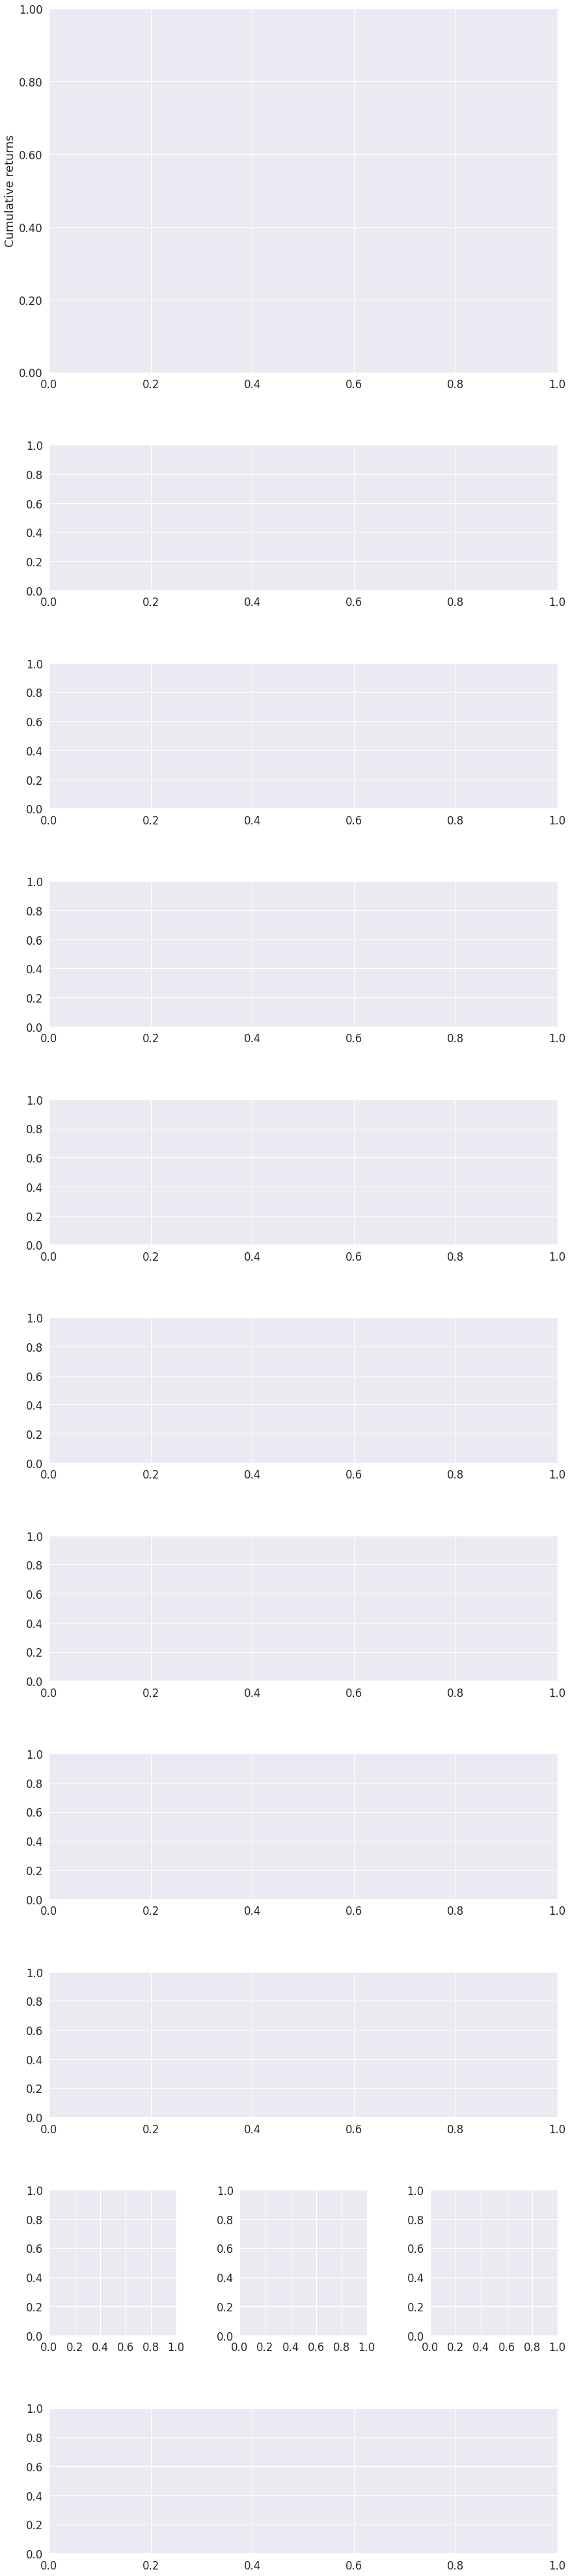

In [11]:
def analyze(perfdata, benchdata):
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perfdata)
    # pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions, benchmark_rets=benchdata)
    pf.create_returns_tear_sheet(returns, benchmark_rets=benchdata)
analyze(perf, bench_series)